In [1]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.palettes import brewer
from bokeh.io import export_svgs
import numpy as np
import json

import matplotlib.pyplot as plt

import scipy
import scipy.stats
import pathlib

import os

os.environ['GILLESPIE'] = '/dev/shm/Git/Gillespie/cmake-build-release/Gillespie'

output_notebook()

Loading BokehJS ...

In [2]:
from analyzer import analyzer

In [17]:
data = analyzer.load_trajectory(pathlib.Path('/dev/shm/response.traj'))

In [18]:
data

{'components': {'X': array([101., 102., 103., ...,  86.,  87.,  86.])},
 'random_variates': array([0.42648376, 0.69377683, 0.96333153, ..., 0.5313974 , 0.29213739,
        0.73452205]),
 'reaction_events': array([0, 0, 0, ..., 0, 0, 1]),
 'reactions': [{'k': 0.02, 'reactants': ['S']},
  {'k': 0.1, 'reactants': ['X']}],
 'timestamps': array([4.26000273e-02, 6.07283563e-02, 6.25702379e-02, ...,
        9.94809004e+02, 9.94881135e+02, 9.94899137e+02])}

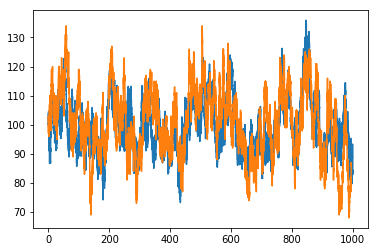

In [20]:
signal = analyzer.load_trajectory(pathlib.Path('/dev/shm/signal.traj'))
plt.plot(signal['timestamps'], signal['components']['S'] * 0.2);
plt.plot(data['timestamps'], data['components']['X'])

In [3]:
analyzer.save_signal('S', '/dev/shm/signal.traj', mean=500, correlation_time=10)

In [15]:
def load_signal(i):
    return analyzer.load_trajectory(pathlib.Path('/data/signal/sig{}.traj'.format(i)))

def load_response(sig, res):
    return analyzer.load_trajectory(pathlib.Path('/data/response/res{}-{}.traj'.format(sig, res)))

In [16]:
def show_hist(data):
    hist, edges = np.histogram(data, bins='auto')
    p = figure()
    p.vbar(x=edges[:-1], width=np.diff(edges), top=hist)
    show(p)

In [19]:
sig = load_signal(1)
sig2 = load_signal(2)
res = load_response(1,0)

show_hist(analyzer.likelihoods_given_signal(res, sig))
show_hist(analyzer.likelihoods_given_signal(res, sig2))

loading /data/signal/sig1.traj
loading /data/signal/sig2.traj
loading /data/response/res1-0.traj


In [92]:
res

{'components': {'S': array([10000.        , 10000.        , 10000.        , ...,
          8479.54115354,  8479.54115354,  8479.54115354]),
  'X': array([19999., 19998., 19999., ...,  5106.,  5105.,  5104.])},
 'random_variates': array([0.59284462, 0.85794562, 0.6235637 , ..., 0.01055245, 0.33331428,
        0.06084393]),
 'reaction_events': array([1, 1, 0, ..., 0, 1, 1]),
 'reactions': [{'k': 1.0, 'reactants': ['S']}, {'k': 0.5, 'reactants': ['X']}],
 'timestamps': array([2.61411472e-05, 3.38020668e-05, 5.74184656e-05, ...,
        1.02090469e+02, 1.02090693e+02, 1.02091264e+02])}

In [44]:
x = np.stack([s['timestamps'] for s in signals])
y = np.stack([s['components']['S'] for s in signals])

In [45]:
y

array([[    0.        ,     0.        , 10000.        , ...,
         3918.52060142,  3918.52060142,  3918.52060142],
       [    0.        ,     0.        , 10000.        , ...,
         4190.60580987,  4184.1984197 ,  4184.1984197 ],
       [    0.        , 10000.        , 10000.        , ...,
         3703.37551146,  3703.37551146,  3703.37551146],
       ...,
       [10000.        , 10000.        , 10000.        , ...,
         3709.0890929 ,  3709.0890929 ,  3709.0890929 ],
       [10000.        , 10000.        , 10000.        , ...,
         4113.89341775,  4113.89341775,  4113.89341775],
       [10000.        , 10000.        , 10000.        , ...,
         4039.11215283,  4039.11215283,  4039.11215283]])

In [46]:
palette = brewer['Dark2'][8]

In [47]:
# create a new plot with a title and axis labels
p = figure(title="Trajectories", x_axis_label='t / s', y_axis_label='copies')

# add a line renderer with legend and line thickness
for (x_ax, y_ax), col in zip(zip(x, y), palette):
    res_x = np.linspace(np.min(x_ax), np.max(x_ax), 1000)
    p.line(res_x, np.interp(res_x, x_ax, y_ax), line_width=2, color=col)

show(p)

In [ ]:
np.savetxt("tr2.txt", [x, y[1]])

In [ ]:
np.concatenate(([int_x], int_y), axis=0)

In [ ]:
p = figure()
p.line(int_x, int_y[0])
p.line(int_x, int_y[1])
show(p)

In [ ]:
hist = np.histogram(np.log(np.diff(txt_data[0])), bins='auto', density=True)
p=figure()
p.vbar(hist[1][:-1], width=np.diff(hist[1]), top=hist[0])
show(p)

In [ ]:
hist[0]

In [ ]:
np.loadtxt("tr2.txt").shape

In [ ]:
int_x

In [ ]:
def ornstein_uhlenbeck_path(x0, t, mean_rev_speed, mean_rev_level, vola):
    """ Simulates a sample path for an Ornstein-Uhlenbeck process."""
    assert len(t) > 1
    x = scipy.stats.norm.rvs(size=len(t))
    x[0] = x0
    dt = np.diff(t)
    scale = std(dt, mean_rev_speed, vola)
    x[1:] = x[1:] * scale
    for i in range(1, len(x)):
        x[i] += mean(x[i - 1], dt[i - 1], mean_rev_speed, mean_rev_level)
    return x

def std(t, mean_rev_speed, vola):
    return np.sqrt(variance(t, mean_rev_speed, vola))

def variance(t, mean_rev_speed, vola):
    assert mean_rev_speed >= 0
    assert vola >= 0
    return vola * vola * (1.0 - np.exp(- 2.0 * mean_rev_speed * t)) / (2 * mean_rev_speed)

def mean(x0, t, mean_rev_speed, mean_rev_level):
    assert mean_rev_speed >= 0
    return x0 * np.exp(-mean_rev_speed * t) + (1.0 - np.exp(- mean_rev_speed * t)) * mean_rev_level

In [ ]:
times = np.linspace(0, 100, 100000)
x = ornstein_uhlenbeck_path(10000, times, 0.001, 10000, 900)
p = figure()
p.line(times, x)
show(p)

In [ ]:
json_obj = { 'timestamps': times.tolist(), 'components': [x.tolist()] }
with open("response/ouproc.txt", "w") as outfile:
    json.dump(json_obj, outfile)